In [1]:
import numpy as np
import pandas as pd
import scipy, requests, codecs, os, re, nltk, itertools, csv
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from scipy.stats import spearmanr
import functools as ft
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import gdown
import json

In [2]:
VEC_LEN = 300
glove_file = open("data/glove_wiki_vectors.txt", 'r')
glove_word = {}
for line in glove_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    glove_word[_word[0]] = vector
glove_file.close()
print(len(glove_word))

322636


In [3]:
VEC_LEN = 300
debias_file = open("./Hard_Debias/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin", 'r')
debias_word = {}
for line in debias_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    debias_word[_word[0]] = vector
debias_file.close()
print(len(debias_word))

322636


In [3]:
def doPCA(pairs, embedding, num_components = 10):
    matrix = []
    for a, b in pairs:
        a = a.lower()
        b = b.lower()
        try:
            center = (embedding[a] + embedding[b])/2
            matrix.append(embedding[a] - center)
            matrix.append(embedding[b] - center)
        except:
            print("error", a, b)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca



In [4]:
with open('./definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('./equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


## Word Projection Task

In [98]:
def word_projection(defs, glove_word, k, comp):
    pca = doPCA(defs, glove_word)
    comp = pca.components_[:k]
    gender_word = []
    for w in gender_specific_words:
        if w in glove_word.keys():
            gender_word.append(w)
    n = len(gender_word)
    total = 0
    for w in gender_word:
        d = comp.dot(glove_word[w])
        total += np.linalg.norm(d)
    pro1 = total / n
    print("Gender projection :", pro1)
    # random group
    np.random.seed(184)
    control = np.random.choice(list(glove_word.keys()), n)
    total = 0
    for w in control:
        total += np.linalg.norm(comp.dot(glove_word[w]))
    pro2 = total / n
    print("Random group :", pro2)
    print("Gap :", (pro1 - pro2) / pro1)

In [99]:
print("When k=1")
word_projection(defs, glove_word, 1, comp)
print("When k=2")
word_projection(defs, glove_word, 2, comp)
print("When k=3")
word_projection(defs, glove_word, 3, comp)

When k=1
205
Gender projection : 1.1002250230118629
Random group : 0.34114585075451126
Gap : 0.6899308381292533
When k=2
205
Gender projection : 1.3781663564516313
Random group : 0.5892525589502762
Gap : 0.5724372778425485
When k=3
205
Gender projection : 1.4616985587626459
Random group : 0.6934941328344936
Gap : 0.5255559850715398


## Simialrity Correlation Task

In [ ]:
pca = doPCA(defs, glove_word)
comp = pca.components_[:1]

In [31]:
import json 

def extract_professions():
    professions = []
    with codecs.open('./data/HSR/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()

In [32]:
gender_specific = []
with open('./data/HSR/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/HSR/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific
print(len(exclude_words))

446


In [33]:
import string 
from tqdm import tqdm

def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(word_embedding, exclude = None, vec_len = 300):
    vocab_limited = []
    for w in tqdm(list(word_embedding.keys())[:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        # vocab_limited = list(set(vocab_limited) - set(exclude) - {'melville', 'null', 'nan', 'castellón', 'sgc'})
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    return vocab_limited

word_limited = limit_vocab(glove_word, exclude_words)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 470332.62it/s]

size of vocabulary: 47698


In [34]:
import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    return pearson(a,b)

In [35]:
def word_vec(word_embedding, word_list):
    word_limited_vec = []
    for w in word_list:
        word_limited_vec.append(word_embedding[w])
    word_limited_vec = np.array(word_limited_vec)
    return word_limited_vec

word_limited_vec = word_vec(glove_word, word_limited)

In [36]:
def get_tuples_prof(word_embedding, words, word_list, word_limited_vec, gender_bias_dict, b=0.2):

    tuples = []
    
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        # top = topK(w, space, k=105)[:100]
        vec = word_embedding[w]
        sim = word_limited_vec.dot(vec)
        sort_sim = (sim.argsort())[::-1]
        best = sort_sim[:(105+1)]
        
        # if w in words:
        #     print(w)
        # idx = word_list.index(w)
        top = []
        for i in best:
            if word_list[i] != w:
                top.append(word_list[i])
            # else:
                # print("___________________")
                # print(w)
                # raise Exception("Same Word Error")
            
        m = 0
        f = 0  
        for t in top[:100]:          
            if gender_bias_dict[t] > b:
                m+=1
            if gender_bias_dict[t] < -b:
                f+=1
                
        tuples.append((w, gender_bias_dict[w], 0, m, f))
        
        
    return tuples

In [37]:
def compute_bias_by_projection(word_embedding, word_list, direction):
    d = {}
    # for w,m,f in zip(vocab[space_to_tag], males, females):
    #     d[w] = m-f
    for w in word_list:
        try:
            d[w] = direction.dot(word_embedding[w])[0]
        except Exception:
            print(w)
            continue
    return d

word_project = compute_bias_by_projection(glove_word, word_limited, comp)

In [38]:
prof_glove = get_tuples_prof(glove_word, professions, word_limited, word_limited_vec, word_project)
compute_corr(prof_glove, 1, 3)

(0.7820550863231456, 1.8216573265744813e-53)

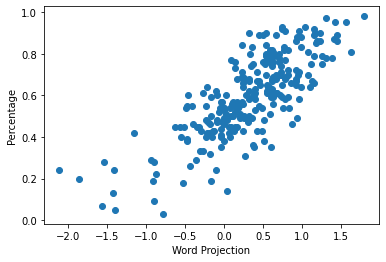

In [39]:
import matplotlib.pyplot as plt
plt.scatter([t[1] for t in prof_glove], [t[3]/100 for t in prof_glove])
plt.xlabel("Word Projection")
plt.ylabel("Percentage")
plt.show()

In [77]:
# normalize
def normalize(word_embedding):
    for word in word_embedding.keys():
        vec = word_embedding[word]
        norm = np.linalg.norm(vec)
        word_embedding[word] = vec / norm

def check_normalize(word_embedding):
    count = 0
    for word in word_embedding.keys():
        vec = word_embedding[word]
        if np.linalg.norm(vec) > 1.0001 or np.linalg.norm(vec) < 0.9999:
            print(word)
            print(count)
            raise Exception("Normalize error")
            
def dim299(word_embedding):
    for w in word_embedding:
        try:
            word_embedding[w] = word_embedding[w][:-1]
            assert(len(word_embedding[w]) == 299)
        except Exception:
            print(w)

glove_word299 = glove_word.copy()
dim299(glove_word299)
normalize(glove_word299)
debias_word299 = debias_word.copy()
dim299(debias_word299)
normalize(debias_word299)

In [42]:
def word_vec299(word_embedding, word_list):
    word_limited_vec = []
    for w in word_list:
        word_limited_vec.append(word_embedding[w])
    word_limited_vec = np.array(word_limited_vec)
    return word_limited_vec

word_limited_vec299 = word_vec(glove_word299, word_limited)

In [43]:
def compute_bias_by_projection_org(word_embedding, word_list):
    direction = word_embedding['he'] - word_embedding['she']
    # males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    # females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    # for w,m,f in zip(vocab[space_to_tag], males, females):
    #     d[w] = m-f
    for w in word_list:
        try:
            d[w] = word_embedding[w].dot(direction)
        except Exception:
            print(w)
            continue
    return d

word_project_org = compute_bias_by_projection_org(glove_word299, word_limited)

In [44]:
def get_tuples_prof_org(word_embedding, words, word_list, word_limited_vec, gender_bias_dict):

    tuples = []
    
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        # top = topK(w, space, k=105)[:100]
        vec = word_embedding[w]
        sim = word_limited_vec.dot(vec)
        sort_sim = (sim.argsort())[::-1]
        best = sort_sim[:(105+1)]
        
        # if w in words:
        #     print(w)
        # idx = word_list.index(w)
        top = []
        for i in best:
            if word_list[i] != w:
                top.append(word_list[i])
            # else:
                # print("___________________")
                # print(w)
                # raise Exception("Same Word Error")
            
        m = 0
        f = 0  
        for t in top[:100]:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_dict[w], 0, m, f))
        
        
    return tuples

prof_glove_org = get_tuples_prof_org(glove_word299, professions, word_limited, word_limited_vec299, word_project_org)

In [45]:
compute_corr(prof_glove_org, 1, 3)

(0.8190502234926496, 1.665581362495172e-62)

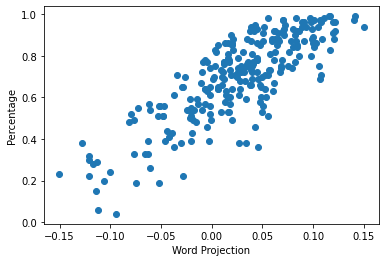

In [46]:
import matplotlib.pyplot as plt
plt.scatter([t[1] for t in prof_glove_org], [t[3]/100 for t in prof_glove_org])
plt.xlabel("Word Projection")
plt.ylabel("Percentage")
plt.show()

## Association classification task

### RNSB

In [4]:
male = []
female = []
with open('./data/HSR/male_word_file.txt') as f:
    for l in f:
        male.append(l.strip())
with open('./data/HSR/female_word_file.txt') as f:
    for l in f:
        female.append(l.strip())

exclude_words = male + female
print(len(exclude_words))

446


In [5]:
attribute_sets=[["footballer", 'engineer', 'physician', 'doctor', 'laborer', 'proprietor', 'operator', 'mechanic', 'surveyor', 'physicist', 'machinist', 'architect', 'photographer', 'optometrist', 'millwright', 'sales', 'manager'],
                ["hairdresser","receptionist", 'salesperson', 'setter', 'welder', "cleaner" ,'teacher', 'dancer', 'nutritionist', 'dietitian', 'author', 'nurse', 'attendant', 'waitstaff', 'librarian', 'housekeeper', 'model']]

In [6]:
length = min(len(attribute_sets[0]), len(attribute_sets[1]))
attribute_sets = attribute_sets[0][:length] + attribute_sets[1][:length]
target_sets = [male, female]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy

def rnsb(word_embeddings):

    attribute_embeddings = [word_embeddings[w] for w in attribute_sets]

    target_embeddings = [[], []]
    for w in male:
        if w in word_embeddings.keys():
            target_embeddings[0].append(word_embeddings[w])
    for w in female:
        if w in word_embeddings.keys():
            target_embeddings[1].append(word_embeddings[w])

    calculated_divergences = []
    calculated_negative_sentiment_probabilities = []
    scores = []

    # train the logit with the train data.
    X_train = np.array(target_embeddings[0] + target_embeddings[1])
    Y_train = np.array([1]*len(target_embeddings[0]) + [-1]*len(target_embeddings[1]))
    split = train_test_split(
            X_train,
            Y_train,
            shuffle=True,
            test_size=0.1,
            random_state=0,
            stratify=Y_train,
            )
    X_embeddings_train, X_embeddings_test, y_train, y_test = split
    estimator = LogisticRegression(random_state=0)
    estimator.fit(X_embeddings_train, y_train)
    y_pred = estimator.predict(X_embeddings_test)
    score = estimator.score(X_embeddings_test, y_test)
    # print(y_test)
    # print(y_pred, score)
    probabilities = estimator.predict_proba(attribute_embeddings)
    negative_probabilities = probabilities[:, 1].flatten()
    # for n, w in zip(negative_probabilities, target_sets):
    #     print(n,w)

    normalized_negative_probabilities = np.array(negative_probabilities / np.sum(negative_probabilities))
    # print(normalized_negative_probabilities)
    uniform_dist = (np.ones(normalized_negative_probabilities.shape[0])* 1/ normalized_negative_probabilities.shape[0])
    kl_divergence = entropy(normalized_negative_probabilities, uniform_dist)
    print(kl_divergence)

In [8]:
print("Original GloVe:")
rnsb(glove_word)
print("Hard Debias:")
rnsb(debias_word)

Original GloVe:
0.22399039104982316
Hard Debias:
0.012048994282516507


### SVM

In [34]:
import heapq
def compute_sim(word_embedding, direction):
    
    index = 0
    word_list = []
    count = 0
    for w in list(word_embedding.keys())[:50000]:
        d = word_embedding[w].dot(direction) / (np.linalg.norm(word_embedding[w]) * np.linalg.norm(direction))          
        if count >= 100:
            least = word_list[0]
            if d > least[0]:
                heapq.heappop(word_list)
                heapq.heappush(word_list, (d, w))
        else:
            heapq.heappush(word_list, (d, w))
            count += 1
        index += 1
       
    print(count)
    return word_list

In [35]:
word_list = compute_sim(glove_word, glove_word["he"] - glove_word["she"])

100


In [74]:
from sklearn import svm
from random import shuffle
import random
random.seed(100)
import operator



def train_and_predict(word_embedding):
    
    X_train = [word_embedding[w] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [word_embedding[w] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    return float(sum(accuracy))/len(accuracy)

    
# extract most biased words

size_train = 50
size_test = 200
size = size_train + size_test
sorted_g = sorted(word_project.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(word_project[f] < 0)
for m in males:
    assert(word_project[m] > 0)
shuffle(females)
shuffle(males)

In [78]:
train_and_predict(glove_word299)

1.0

In [79]:
train_and_predict(debias_word299)

0.8025

## WEAT task

In [83]:
def similarity(w1, w2):
    
    return w1.dot(w2)

def s_word(w, A, B, word_embedding, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(similarity(word_embedding[w], word_embedding[a]))
    for b in B:
        mean_b.append(similarity(word_embedding[w], word_embedding[b]))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, word_embedding, all_s_words):
    
    total = 0
    for x in X:
        total += s_word(x, A, B, word_embedding, all_s_words)
    for y in Y:
        total -= s_word(y, A, B, word_embedding, all_s_words)
        
    return total

def effect_size(X, Y, A, B, word_embedding, all_s_words):
    total_x = []
    total_y = []
    
    for x in X:
        total_x.append(s_word(x, A, B, word_embedding, all_s_words))
    for y in Y:
        total_y.append(s_word(y, A, B, word_embedding, all_s_words))
        
    
    mean = sum(total_x)/float(len(total_x)) - sum(total_y)/float(len(total_y))
    std_dev = np.std(total_x + total_y)
    
    if std_dev == 0:
        print("Error! ")
    
    return mean / std_dev


def p_value_exhust(X, Y, A, B, word_embedding):
    
#     if len(X) > 10:
#         print('might take too long, use sampled version: p_value')
#         return
    

    _X = []
    _Y = []
    _A = []
    _B = []
    for x in X:
        if x in word_embedding.keys():
            _X.append(x)
            
    for y in Y:
        if y in word_embedding.keys():
            _Y.append(y)
            
    for a in A:
        if a in word_embedding.keys():
            _A.append(a)
            
    for b in B:
        if b in word_embedding.keys():
            _B.append(b)
            
    length = min(10, len(_X), len(_Y))
    X = _X[:length]
    Y = _Y[:length]
    
    A = _A
    B = _B
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, word_embedding, all_s_words) 
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0

    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, word_embedding, all_s_words) > s_orig:
            larger += 1
    print('num of samples {} '.format(total))
    
    d = effect_size(X, Y, A, B, word_embedding, all_s_words)

    
    return larger/float(total), d

In [89]:
X = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
Y = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
A = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
B = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0, 1.9084065924005231)
num of samples 12870 
(0.0001554001554001554, 1.687530397554141)


In [90]:
A = ['judge', 'physician', 'doctor', 'laborer', 'conservationist', 'proprietor', 'operator', 'mechanic', 'surveyor']
B = ['bankteller', 'cashier', 'librarian', 'accountant' , 'teacher', 'baker', 'nurse', 'secretary', 'clerical']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0006216006216006216, 1.475577799823717)
num of samples 12870 
(0.7236208236208236, -0.3175661603956806)


In [85]:
A = ['caress', 'health', 'love', 'heaven', 'pleasure', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'sunrise', 'bright', 'happy', 'laughter']
B = ['bitter', 'crash', 'filth', 'cry', 'grief', 'stink', 'assault', 'disaster', 'angry', 'tragedy', 'divorce', 'fragile', 'poverty', 'ugly', 'sad', 'rotten']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.08865578865578866, 0.7066670479948265)
num of samples 12870 
(0.298989898989899, 0.28072604826530456)


In [87]:
X = ['he', 'his', 'male', 'son', 'mr', 'gentle', 'boy', 'father']
Y = ['she', 'her', 'female', 'daughter', 'mrs', 'lady', 'girl', 'mother']
A = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
B = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0822066822066822, 0.7270437807678093)
num of samples 12870 
(0.4515928515928516, 0.061243357016024236)


In [ ]:
A = ['judge', 'physician', 'doctor', 'laborer', 'conservationist', 'proprietor', 'operator', 'mechanic', 'surveyor']
B = ['bankteller', 'cashier', 'librarian', 'accountant' , 'teacher', 'baker', 'nurse', 'secretary', 'clerical']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0001554001554001554, 1.6109151334676957)
num of samples 12870 
(0.20458430458430457, 0.43628530086089257)


In [88]:
A = ['caress', 'health', 'love', 'heaven', 'pleasure', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'sunrise', 'bright', 'happy', 'laughter']
B = ['bitter', 'crash', 'filth', 'cry', 'grief', 'stink', 'assault', 'disaster', 'angry', 'tragedy', 'divorce', 'fragile', 'poverty', 'ugly', 'sad', 'rotten']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.17956487956487957, 0.5009753645477947)
num of samples 12870 
(0.25555555555555554, 0.37029600908126753)
